James Telzrow \
2023-06-23 \
Warburton Lab \
Schrodinger Time Independent Equation with Discrete Potential Energy Values

## Introduction

This notebook contains code to numerically approximate the solution of the *Time-independent Schrodinger equation* for a particle in a one-dimensional space with potential energy given as a set of discrete points, on which interpolation is performed to create a smooth potential energy function.

Suppose there exists a particle in a one-dimensional space (that is, on the x-axis.)
Let this particle have mass $m$ and a definite quantity of energy $E$, and let the particle have potential energy $V(x)$ when the particle is at point $x$.
Then this particle's wave functions $\psi(x)$ are those that satisfy the *Time-independent Schrodinger equation*:
\begin{equation}
    E\psi(x) = -\frac{\hbar^2}{2m}\frac{d^2\psi(x)}{dx^2} + V(x)\psi(x)
\end{equation}
where $\hbar$ is the reduced Planck constant, $\hbar = \frac{h}{2}$.

## Numerical Solution Using Discrete Potential Values

Suppose that you are not given $V(x)$ explicitly, but are instead given values of $V(x)$ for several values of $x$.
(For example, we may be given that $V(-1) = 1.5, V(-0.5) = 0.375, \dots$)
To solve Equation $(1)$ using these potential values, begin by putting them in the `pot_datapoints` list below as a two-element list, in which the first value is $x$ and the second value is $V(x)$.
(So for example, if you are given $V(-2) = 6$, you should add `[-2, 6],` in the `pot_datapoints` list below.)

In [14]:
pot_datapoints = [
    [-3, 4.5],
    [-2, 2],
    [-1, 0.5],
    [0, 0],
    [1, 0.5],
    [2, 2],
    [3, 4.5],
]

compare_to_QHO = True


Aside:

The cell below can be used to test the accuracy of the approximations created by the  code in this notebook.
It generates the potential energy data for the Quantum Harmonic Oscillator and defines energy level and spring constant variables necessary to create a numerical approximation for such a system.
If `compare_to_QHO` is true, then the cell below will do this, and the cell that actually creates the numerical approximation (several cells below this one) will use the corresponding energy of the QHO ($E_n = \hbar\sqrt{\frac{k}{\text{mass}}}(n + 0.5)$, where $n$ is the integer `energy_level_QUO`) when creating the approximation.
Then, the resulting approximation can be compared to the solutions given in the notebook titled *Schrodinger Time Independent Equation with Quadratic Potential (Quantum Harmonic Oscillator)*, also in this repo.

If you want to solve Equation $(1)$ using your own data, then supply it in `pot_datapoints` and leave `compare_to_QHO` set to false.

In [15]:
if compare_to_QHO:
    from math import sqrt
    import numpy as np

    # The energy of the particle/QHO
    energy_level_QUO = 1
    # The "spring constant" of the particle/QHO
    k = 1
    # The points at which the potential energy will be evaluated
    test_pot_eval_pts = np.arange(-3, 3 + 0.01, 1)
    # Evaluate the QHO potential energy func at the given points
    test_pot_pts = np.square(test_pot_eval_pts)*(k / 2)
    pot_datapoints = np.column_stack((test_pot_eval_pts, test_pot_pts))


Next, this creates a cubic spline using the data contained in `pot_datapoints`, evaluates this spline on the smallest interval containing the x-values said data, and plots the results (along with the original `pot_datapoints` points.)

Text(0.5, 1.0, 'Potential energy of particle')

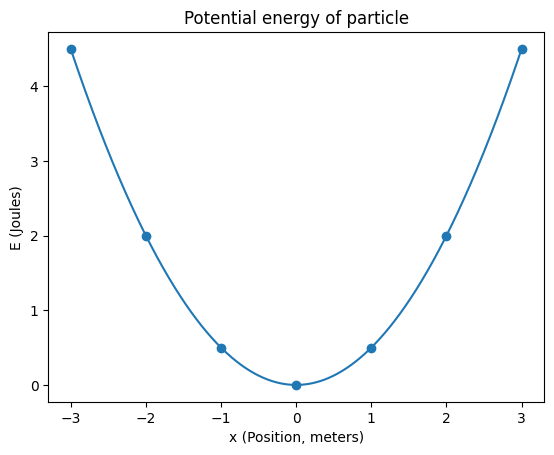

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

pot_datapoints = np.array(pot_datapoints)
x_coords = pot_datapoints[:, :1].flatten()
y_coords = pot_datapoints[:, 1:2].flatten()

# Create a cubic spline using the supplied potential energy data
pot_cs = CubicSpline(x_coords, y_coords)

# The lower bound of the interval within which potential energy data has
# been given
lower_bound = x_coords.min()
# The upper  bound of that interval
upper_bound = x_coords.max()
interval_length = upper_bound - lower_bound
# The number of points at which to evaluate the potential energy cubic
# spline
number_of_eval_points = 1000

# Evaluate the cubic spline for the potential energy, so we can plot it
eval_points = np.arange(lower_bound, upper_bound,
                        interval_length/number_of_eval_points)
interpol_points = pot_cs(eval_points)

# Plot the potential energy cubic spline
plt.scatter(x_coords, y_coords)
plt.plot(eval_points, interpol_points)
plt.xlabel('x (Position, meters)')
plt.ylabel('E (Joules)')
plt.title('Potential energy of particle')


Next, this performs numerical approximation using SciPy's [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) method on the smallest interval containing the x-values of all the given `pot_datapoints`, and plots the result itself as well as the squared magnitude of the result.
In order to do this, you must provide values for:
* `m`: the mass of the particle, in kilograms.
* `E`: the fixed energy of the particle, in Joules
* `m_s_s`: the maximum step size $(\Delta x)$ to use during numerical approximation.
* **Either**: `init_psi_val` and `init_d_psi_dx_val`, **or**: `initial_values` and `init_val_delta_x`.

Let $x_{\text{min}}$ be the lower bound of the smallest interval containing the x-alues of `pot_datapoints`.
(That is, the least x-coordinate of all points in `pot_datapoints`.)
In order to create a numeric solution, `solve_ivp` requires the values of $\psi(x_{\text{min}})$ and $\frac{d\psi(x_{\text{min}})}{dx}$.
(These are the initial values.)
If you know them, you can supply them as `init_psi_val` and `init_d_psi_dx_val`.
However, if you don't know the value of $\frac{d\psi(x_{\text{min}})}{dx}$, then you must supply two values for $\psi(x)$.
The first must be $\psi(x_{\text{min}})$, and the second must be $\psi(x_{\text{min}} + \Delta x)$ for some small positive value of $\Delta x$.
You must supply $\psi(x_{\text{min}})$ and $\psi(x_{\text{min}} + \Delta x)$ as `initial_values`, as the first and second elements in a two-element list, and then you must supply $\Delta x$ as `init_val_delta_x`.

You can also plot normalized solution (the solution such that $\int |\psi(x)|^2 dx = 1$ when integrated on the smallest interval containing all the x-coordinates of `pot_datapoints`) by setting `normalize_soln` to true.

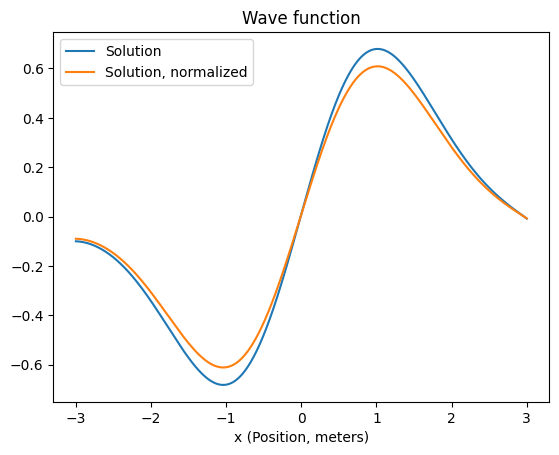

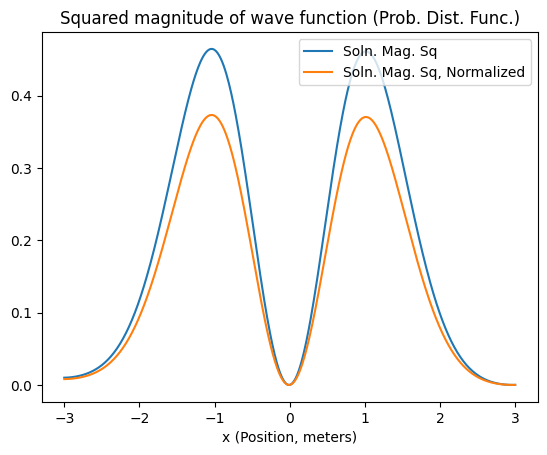

In [17]:
from scipy.integrate import solve_ivp

# Reduced Planck Constant, in Joule seconds
hbar = 1.054_571_817e-34

# Determines whether the solution will be normalized so that the
# integral of |psi(x)|^2 on the smallest interval containing the all
# x-coords of pot_datapoints equals one
normalize_soln = True
# The mass of the particle, in kilograms
m = 1e-68
# The fixed energy of the particle, in Joules
E = 1.5818577255
if compare_to_QHO:
    E = hbar*sqrt(k/m)*(energy_level_QUO + 0.5)
# The maximum step size (in meters) to use when creating the numerical
# approximation
m_s_s = 0.01

# The initial value of psi(x) at lower_bound
init_psi_val = -0.1
# The initial value of the first derivative of psi(x) at lower_bound
init_d_psi_dx_val = -0.01

# A list containing values of psi(x) at lower_bound and
# lower_bound + init_val_delta_x
initial_values: [float] = None
# A positive number describing the difference in x-coordinates between
# the two initial psi(x) points, the y-coordinates of which should be in
# the above initial_values list
init_val_delta_x: float = None

# If the user has supplied values for initial_values and
# init_val_delta_x, we use them instead of init_psi_val and
# init_d_psi_dx_val.
if initial_values != None and len(initial_values) == 2 and init_val_delta_x \
        != None:
    init_psi_val = initial_values[0]
    init_d_psi_dx_val = (initial_values[1]-initial_values[0])/init_val_delta_x


# The Schrodinger equation
def diff_eq_for_scipy(x, psi_and_d_psi_dx):
    # The first element in the list psi_and_d_psi_dx will be the
    # previous psi value, and the second will be the previous
    # d_psi_dx_value
    scnd_deriv = (2*m/hbar**2)*(pot_cs(x) - E)*psi_and_d_psi_dx[0]
    return [psi_and_d_psi_dx[1], scnd_deriv]


# Create a numerical approximation of the solution
sol = solve_ivp(diff_eq_for_scipy, [lower_bound, upper_bound], [
                init_psi_val, init_d_psi_dx_val], max_step=m_s_s)
# Squared magnitude of the solution
sol_mag_sq = abs(sol.y[0, :])**2

if normalize_soln:
    from scipy import integrate
    integral = abs(integrate.simpson(sol.t, sol_mag_sq))
    normalized_sol = sol.y[0, :]/integral
    norm_sol_mag_sq = abs(normalized_sol)**2

plt.plot(sol.t, sol.y[0, :], label='Solution')
if normalize_soln:
    plt.plot(sol.t, normalized_sol, label='Solution, normalized')
plt.xlabel('x (Position, meters)')
plt.title('Wave function')
plt.legend()

plt.show()

plt.plot(sol.t, sol_mag_sq, label='Soln. Mag. Sq')
if normalize_soln:
    plt.plot(sol.t, norm_sol_mag_sq, label='Soln. Mag. Sq, Normalized')
plt.xlabel('x (Position, meters)')
plt.title('Squared magnitude of wave function (Prob. Dist. Func.)')
plt.legend()
